In [2]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.stats import pareto
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix
from math import log10
import numpy as np
import networkx as nx
import pickle
from util import *

In [9]:
# use this to select only a subset of the data to speed up processing, None to skip
with open("pkl/preprocessed_bitcoin.pkl", 'rb') as f:
    data = pickle.load(f)

post_num = None

voca2idx = {w: i for i, w in enumerate(data['voca'])}
voca = data['voca']

if not(post_num is None):
    data['posts'] = data['posts'][:post_num]

In [29]:
# user_score = nx.pagerank(data['user_network'], tol=1e-8, max_iter=200)
hubs, user_score = nx.hits(data['user_network'], max_iter=50)
total_user_num = len(data['user_network'].nodes())
top_users = sorted(user_score, key=user_score.get, reverse=True)

fwrite = open('hits_user_score_post_num.tsv', 'w')
fwrite.write("id\tlog id\tuser\tscore\tpost num\tget comment num\twrite comment num\n")
for i, user in enumerate(top_users):
    fwrite.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(
        i + 1, log10(i+1), user, user_score[user], data['user_posts_num'][user], 
        data['get_comment_num'][user], data['write_comment_num'][user]))
fwrite.close()
# 전체 게시물 수와 상위유저+하위유저 게시물 갯수가 다른건 아예 소통이 없던 유저의 게시물이 있기 때문!

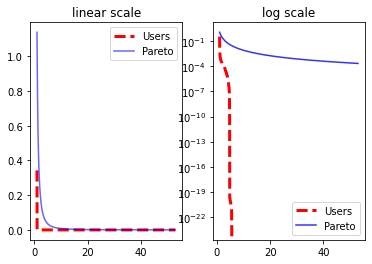

In [30]:
sorted_scores = sorted([v for v in user_score.values()], reverse=True)

# b for standard 80/20 distribution
b = 1.16
fig, ax = plt.subplots(1, 2)
mean, var, skew, kurt = pareto.stats(b, moments='mvsk')
x = np.linspace(pareto.ppf(0.01, b), pareto.ppf(0.99, b), len(sorted_scores))

ax[0].title.set_text("linear scale")
ax[0].plot(x, sorted_scores, "red", lw=3, linestyle='dashed', label='Users')
ax[0].plot(x, pareto.pdf(x, b), 'blue', alpha=0.6, label='Pareto')

ax[1].title.set_text("log scale")
ax[1].set_yscale('log')
ax[1].plot(x, sorted_scores, "red", lw=3, linestyle='dashed', label='Users')
ax[1].plot(x, pareto.pdf(x, b), 'blue', alpha=0.8, label='Pareto')

ax[0].legend()
ax[1].legend()

In [22]:
users = {u: len(v) for u, v in sorted(data['user_network'].adj.items(), key=lambda e: len(e[1]), reverse=True)}

for user, n_adj in users.items():
    print(user, n_adj, user_score[user])

Coinforecaster 51 -0.0
Don't ask 35 -0.0
Master⚡️500k BTC 12k LTC 2021 super cycle 32 -0.0
BitcoinT.I.N.A.☣️- "TINA" #bitcoin 27 -0.0
Danila Kotov $ppt, $hive 25 -0.0
🔥🔥🔥🐺GERI & FREKI🐺🔥🔥🔥 22 -0.0
if (BTC.IsSoV) {Titanic.IsStoreOfPassengers=true}; 22 -0.0
zender 🟨⬛ Taproot by BIP8 (false, 1 year) 21 -0.0
Jesus Christ 21 -0.0
Mike 20 -0.0
Frogolocalypse 18 -0.0
🧐 Bitcoin Gent! 🧐 18 -0.0
Paul Heller, Founder ONVR 18 -0.0
antiprosynthesis.eth ⟠ 17 -0.0
Bitcoin Theory 17 -0.0
Satoshi’s Disciple (₿) 17 -0.0
CedRacine in BTC I trust 16 -0.0
Vladislav Ginko 16 -0.0
Dictator know it all 😜 16 -0.0
hastytoro™ 16 -0.0
Psychedelic El ₿arto 15 -0.0
. 15 -0.0
pepelink 15 -0.0
Satoshi&Co 15 -0.0
Gabor Gurbacs 14 -0.0
Fid Laf 13 -0.0
XareP 13 -0.0
Bitcoin Love Song 日本 - 2010 o.g. 13 -0.0
David 13 -0.0
Paul McNeal #BTC100K 🔥 🚀 🏳️‍🌈 🧢 13 -0.0
Udi Wertheimer 12 -0.0
Sampo 🦕🦖💥₿☄️ 12 -0.0
Marco nicolo 12 -0.0
Adam Back 12 -0.0
Primal Digest 12 -0.0
Dogestradamus🐶芝シ犬 中本🐕 12 -0.0
Alex 12 -0.0
HappyViking888 1

In [5]:
# construct the term frequency matrix for entier community and run 
# topic modeling for it
counter = 0
total_len = len(data['posts'])

tdm = dok_matrix((len(data['posts']), len(voca)), dtype=np.float32)
for i, post in enumerate(data['posts']):

    if counter % 1000 == 0:
        print(f"\r{counter/total_len * 100:.2f}% done", end='')

    for word in post:
        tdm[i, voca2idx[word]] += 1

    counter += 1
        

print(f"\r{100:.2f}% done", end='')

tdm = normalize(tdm)
# compressed sparse row matrix, where row operations are rendered more efficient
# in our case documents are stored in the rows
tdm = tdm.tocsr()
print(tdm.shape)

100.00% done(10000, 67243)


In [6]:
K = 10
nmf = NMF(n_components=K, alpha=0.1, max_iter=500)
nmf.fit(tdm)
H_total = nmf.components_

/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [8]:
# 상위 유저 분석!
# segregate users based on hits algorithm. Moving those in the top
# 20 percent into a separate group. top_index is just the cutoff
# point for where this gruop is
acc_sum = 0
top_index = 0
score_sum = sum(user_score.values())
for i, top_user in enumerate(sorted(user_score, key=user_score.get, reverse=True)):
    acc_sum += user_score[top_user]/score_sum
    if acc_sum > 0.8:
        top_index = i
        break

top_users = top_users[:top_index]

sum 1.000000000000001


In [13]:
user_posts = []
for user in top_users:
    for post in data['user_posts'][user]:
        user_posts.append(post)

In [14]:
# TDM for top users
tdm = dok_matrix((len(user_posts), len(voca)), dtype=np.float32)
for i, post in enumerate(user_posts):
    for word in post:
        tdm[i, voca2idx[word]] += 1
        
tdm = normalize(tdm)
tdm = tdm.tocsr()
print(tdm.shape)

(26107, 67243)


In [15]:
nmf = NMF(n_components=K, alpha_H=0.1, alpha_W=0.1, max_iter=500)
nmf.fit(tdm)
H_top = nmf.components_

/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


In [16]:
# 하위 유저 분석!
low_users = sorted(user_score, key=user_score.get, reverse=False)[:-top_index]

user_posts = []
for user in low_users:
    for post in data['user_posts'][user]:
        user_posts.append(post)

In [17]:
# TDM for majority users
tdm = dok_matrix((len(user_posts), len(voca)), dtype=np.float32)
for i, post in enumerate(user_posts):
    for word in post:
        tdm[i, voca2idx[word]] += 1
        
tdm = normalize(tdm)
tdm = tdm.tocsr()
print(tdm.shape)

(577690, 67243)


In [18]:
nmf = NMF(n_components=K, alpha=0.1, max_iter=500)
nmf.fit(tdm)
H_low = nmf.components_

/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


In [1]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment

# hungarian algorithm
top_distances = pairwise_distances(H_total, H_top, metric='cosine')
_, top_indices = linear_sum_assignment(top_distances)

low_distances = pairwise_distances(H_total, H_low, metric='cosine')
_, low_indices = linear_sum_assignment(low_distances)

top_similarity_average = 0
low_similarity_average = 0

top_similarities = []
low_similarities = []

for k in range(K):
    top_similarity = cosine_similarity(H_top[top_indices[k]].reshape(1, -1), H_total[k].reshape(1,-1))[0, 0]
    low_similarity = cosine_similarity(H_low[low_indices[k]].reshape(1, -1), H_total[k].reshape(1,-1))[0, 0]
    top_similarity_average += top_similarity
    low_similarity_average += low_similarity

    top_similarities.append(top_similarity)
    low_similarities.append(low_similarity)
   
    print(f"total users: {k}th topic")
    for i in H_total[k, :].argsort()[::-1][:20]:
        print(voca[i], end=' ')
    print()
    
    print(f"top users: {top_indices[k]}th topic, similarity - {top_similarity}")
    for i in H_top[top_indices[k]].argsort()[::-1][:20]:
        print(voca[i], end=' ')
    print()
    
    print(f"majority users: {low_indices[k]}th topic, similarity - {low_similarity}")
    for i in H_low[low_indices[k]].argsort()[::-1][:20]:
        print(voca[i], end=' ')
    print()
    
    print()
    
top_similarity_average /= K
low_similarity_average /= K

print(top_similarity_average, low_similarity_average)

NameError: name 'H_total' is not defined

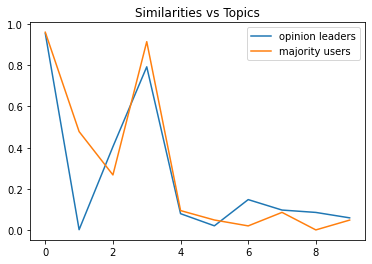

In [124]:
'''
The graph of the similarity scores between majority and opinion leaders vs the H_total
'''
x = range(len(top_similarities))

plt.title('Similarities vs Topics')
plt.plot(x, top_similarities, label='opinion leaders')
plt.plot(x, low_similarities, label='majority users')
plt.legend()
plt.show()